In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix

# 1. Data Preprocessing

### Loading the dataset

In [2]:
#import dataset
fake = pd.read_csv("fakeNews.csv")
true = pd.read_csv("trueNews.csv")

In [3]:
#data exploration
fake

,Date Posted,Link,Text,Region,Country,Explanation,Origin,Origin_URL,Fact_checked_by,Poynter_Label,Binary Label
0,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Tencent revealed the real number of deaths.\t\t,Europe,France,The screenshot is questionable.,Twitter,https://www.liberation.fr/checknews/2020/02/07...,CheckNews,Misleading,0
1,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Taking chlorine dioxide helps fight coronavir...,Europe,Germany,Chlorine dioxide does guard against the coron...,Website,https://correctiv.org/faktencheck/medizin-und-...,Correctiv,FALSE,0
2,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,This video shows workmen uncovering a bat-inf...,India,India,A video shows bats nesting in the roof; howev...,Facebook,https://factcheck.afp.com/video-shows-workmen-...,AFP,MISLEADING,0
3,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,The Asterix comic books and The Simpsons pred...,India,India,Coronavirus has been around since the 1960s. ...,Twitter,https://www.boomlive.in/health/did-the-simpson...,BOOM FactCheck,Misleading,0
4,2/7/20,https://www.poynter.org/?ifcn_misinformation=c...,Chinese President Xi Jinping visited a mosque...,India,India,Chinese President Xi Jinping's visit to the m...,Facebook,http://newsmobile.in/articles/2020/02/07/chine...,NewsMobile,FALSE,0
...,...,...,...,...,...,...,...,...,...,...,...
3790,6/23/20,https://www.poynter.org/?ifcn_misinformation=b...,Bill Gates said that the COVID-19 vaccine wil...,Europe,Spain,The new RNA and DNA vaccine candidates are ex...,Social Media and Websites,https://www.newtral.es/bill-gates-vacuna-coron...,Newtral.es,FALSE,0
3791,6/23/20,https://www.poynter.org/?ifcn_misinformation=c...,COVID-19 vaccine candidates will insert micro...,Europe,Spain,The hoax comes from a misinterpretation of a ...,Whatsapp and Facebook,https://www.newtral.es/bulo-vacuna-coronavirus...,Newtral.es,FALSE,0
3792,6/23/20,https://www.poynter.org/?ifcn_misinformation=a...,An image claims that chroma screen panels are...,Europe,Spain,The image has been manipulated. The real one ...,Social Media,https://www.newtral.es/bulo-croma-inventar-mue...,Newtral.es,FALSE,0
3793,6/23/20,https://www.poynter.org/?ifcn_misinformation=a...,"Alexandria Ocasio-Cortez tweeted, ""It's vital...",United States,United States,Alexandria Ocasio-Cortez didn't tweet this.,Viral image,https://www.politifact.com/factchecks/2020/jun...,PolitiFact,FALSE,0


In [4]:
fake = fake.drop("Binary Label", axis=1) 

In [5]:
fake["label"] = 1

In [6]:
fake.head(10)

,Date Posted,Link,Text,Region,Country,Explanation,Origin,Origin_URL,Fact_checked_by,Poynter_Label,label
0,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Tencent revealed the real number of deaths.\t\t,Europe,France,The screenshot is questionable.,Twitter,https://www.liberation.fr/checknews/2020/02/07...,CheckNews,Misleading,1
1,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Taking chlorine dioxide helps fight coronavir...,Europe,Germany,Chlorine dioxide does guard against the coron...,Website,https://correctiv.org/faktencheck/medizin-und-...,Correctiv,FALSE,1
2,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,This video shows workmen uncovering a bat-inf...,India,India,A video shows bats nesting in the roof; howev...,Facebook,https://factcheck.afp.com/video-shows-workmen-...,AFP,MISLEADING,1
3,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,The Asterix comic books and The Simpsons pred...,India,India,Coronavirus has been around since the 1960s. ...,Twitter,https://www.boomlive.in/health/did-the-simpson...,BOOM FactCheck,Misleading,1
4,2/7/20,https://www.poynter.org/?ifcn_misinformation=c...,Chinese President Xi Jinping visited a mosque...,India,India,Chinese President Xi Jinping's visit to the m...,Facebook,http://newsmobile.in/articles/2020/02/07/chine...,NewsMobile,FALSE,1
5,2/7/20,https://www.poynter.org/?ifcn_misinformation=c...,"China seeks court approval to kill over 20,00...",United States,United States,There is no evidence that China went to court...,ab,https://hoax-alert.leadstories.com/3471622-fak...,LeadStories,FALSE,1
6,2/8/20,https://www.poynter.org/?ifcn_misinformation=p...,A video shows people screaming in Wuhan becau...,India,India,The video shows Wuhan residents whistling and...,Twitter,https://www.boomlive.in/fake-news/video-of-wuh...,BOOM FactCheck,Misleading,1
7,2/8/20,https://www.poynter.org/?ifcn_misinformation=w...,A video says weed kills coronavirus.\t\t,India,India,The news clip was created through a meme gene...,"Twitter, WhatsApp",https://www.boomlive.in/fake-news/marijuana-ki...,BOOM FactCheck,Misleading,1
8,2/8/20,https://www.poynter.org/?ifcn_misinformation=c...,Coronavirus has been found in broiler chicken...,India,India,The claim is fake.,Facebook,https://www.vishvasnews.com/health/post-claimi...,Vishvas News,FALSE,1
9,2/8/20,https://www.poynter.org/?ifcn_misinformation=i...,In a photo of Pakistani Prime Minister Imran ...,India,India,The image was edited.,Facebook,https://www.vishvasnews.com/politics/fact-chec...,Vishvas News,FALSE,1


In [7]:
true.head(10)

,Date Posted,Link,Text,Region,Username,Publisher,Label
0,2/11/20,https://twitter.com/the_hindu/status/122725962...,Just in: Novel coronavirus named 'Covid-19': U...,India,the_hindu,The Hindu,1
1,2/12/20,https://twitter.com/ndtv/status/12274908434742...,WHO officially names #coronavirus as Covid-19....,India,ndtv,NDTV,1
2,2/12/20,https://twitter.com/the_hindu/status/122744471...,"The #UN #health agency announced that ""COVID-1...",India,the_hindu,The Hindu,1
3,2/14/20,https://twitter.com/IndiaToday/status/12282764...,The Indian Embassy in Tokyo has said that one ...,India,indiatoday,IndiaToday,1
4,2/15/20,https://twitter.com/the_hindu/status/122854247...,Ground Zero | How Kerala used its experience i...,India,the_hindu,The Hindu,1
5,2/15/20,https://twitter.com/the_hindu/status/122865774...,An elderly Chinese tourist hospitalised in Fra...,India,the_hindu,The Hindu,1
6,2/16/20,https://twitter.com/IndiaToday/status/12290293...,The total number of people infected with COVID...,India,indiatoday,IndiaToday,1
7,2/16/20,https://twitter.com/IndiaToday/status/12290784...,COVID-19 coronavirus Updates: Africa has its f...,India,indiatoday,IndiaToday,1
8,2/17/20,https://twitter.com/IndiaToday/status/12292541...,Covid-19 Updates: #Kerala defeats #Coronavirus...,India,indiatoday,IndiaToday,1
9,2/18/20,https://twitter.com/the_hindu/status/122969454...,"#Coronavirus | #LiuZhiming, the head of a lead...",India,the_hindu,The Hindu,1


In [8]:
true = true.drop("Label", axis=1) 

In [9]:
true["label"] = 0

In [10]:
true.head(10)

,Date Posted,Link,Text,Region,Username,Publisher,label
0,2/11/20,https://twitter.com/the_hindu/status/122725962...,Just in: Novel coronavirus named 'Covid-19': U...,India,the_hindu,The Hindu,0
1,2/12/20,https://twitter.com/ndtv/status/12274908434742...,WHO officially names #coronavirus as Covid-19....,India,ndtv,NDTV,0
2,2/12/20,https://twitter.com/the_hindu/status/122744471...,"The #UN #health agency announced that ""COVID-1...",India,the_hindu,The Hindu,0
3,2/14/20,https://twitter.com/IndiaToday/status/12282764...,The Indian Embassy in Tokyo has said that one ...,India,indiatoday,IndiaToday,0
4,2/15/20,https://twitter.com/the_hindu/status/122854247...,Ground Zero | How Kerala used its experience i...,India,the_hindu,The Hindu,0
5,2/15/20,https://twitter.com/the_hindu/status/122865774...,An elderly Chinese tourist hospitalised in Fra...,India,the_hindu,The Hindu,0
6,2/16/20,https://twitter.com/IndiaToday/status/12290293...,The total number of people infected with COVID...,India,indiatoday,IndiaToday,0
7,2/16/20,https://twitter.com/IndiaToday/status/12290784...,COVID-19 coronavirus Updates: Africa has its f...,India,indiatoday,IndiaToday,0
8,2/17/20,https://twitter.com/IndiaToday/status/12292541...,Covid-19 Updates: #Kerala defeats #Coronavirus...,India,indiatoday,IndiaToday,0
9,2/18/20,https://twitter.com/the_hindu/status/122969454...,"#Coronavirus | #LiuZhiming, the head of a lead...",India,the_hindu,The Hindu,0


In [11]:
#combining both the datasets into one
df = pd.concat([fake, true], ignore_index = True)
df

,Date Posted,Link,Text,Region,Country,Explanation,Origin,Origin_URL,Fact_checked_by,Poynter_Label,label,Username,Publisher
0,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Tencent revealed the real number of deaths.\t\t,Europe,France,The screenshot is questionable.,Twitter,https://www.liberation.fr/checknews/2020/02/07...,CheckNews,Misleading,1,NaN,NaN
1,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Taking chlorine dioxide helps fight coronavir...,Europe,Germany,Chlorine dioxide does guard against the coron...,Website,https://correctiv.org/faktencheck/medizin-und-...,Correctiv,FALSE,1,NaN,NaN
2,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,This video shows workmen uncovering a bat-inf...,India,India,A video shows bats nesting in the roof; howev...,Facebook,https://factcheck.afp.com/video-shows-workmen-...,AFP,MISLEADING,1,NaN,NaN
3,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,The Asterix comic books and The Simpsons pred...,India,India,Coronavirus has been around since the 1960s. ...,Twitter,https://www.boomlive.in/health/did-the-simpson...,BOOM FactCheck,Misleading,1,NaN,NaN
4,2/7/20,https://www.poynter.org/?ifcn_misinformation=c...,Chinese President Xi Jinping visited a mosque...,India,India,Chinese President Xi Jinping's visit to the m...,Facebook,http://newsmobile.in/articles/2020/02/07/chine...,NewsMobile,FALSE,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7583,6/30/20,https://twitter.com/ReutersUK/status/127789851...,Global COVID-19 prevention trial of hydroxychl...,Europe,NaN,NaN,NaN,NaN,NaN,NaN,0,reutersuk,Reuters UK
7584,6/30/20,https://twitter.com/ReutersUK/status/127798902...,Bavaria's free COVID-19 test for all splits Ge...,Europe,NaN,NaN,NaN,NaN,NaN,NaN,0,reutersuk,Reuters UK
7585,6/30/20,https://twitter.com/ReutersUK/status/127787577...,Britain locks down city of Leicester after COV...,Europe,NaN,NaN,NaN,NaN,NaN,NaN,0,reutersuk,Reuters UK
7586,6/30/20,https://twitter.com/ReutersUK/status/127778649...,UK imposes lockdown on city of Leicester to cu...,Europe,NaN,NaN,NaN,NaN,NaN,NaN,0,reutersuk,Reuters UK


### Data Cleaning

In [12]:
df.dtypes

Date Posted        object
Link               object
Text               object
Region             object
Country            object
Explanation        object
Origin             object
Origin_URL         object
Fact_checked_by    object
Poynter_Label      object
label               int64
Username           object
Publisher          object
dtype: object

In [13]:
data = df.drop(["Country", "Explanation", "Origin", "Origin_URL", "Fact_checked_by", "Poynter_Label", "Username", "Publisher"], axis=1)

In [14]:
data

,Date Posted,Link,Text,Region,label
0,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Tencent revealed the real number of deaths.\t\t,Europe,1
1,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Taking chlorine dioxide helps fight coronavir...,Europe,1
2,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,This video shows workmen uncovering a bat-inf...,India,1
3,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,The Asterix comic books and The Simpsons pred...,India,1
4,2/7/20,https://www.poynter.org/?ifcn_misinformation=c...,Chinese President Xi Jinping visited a mosque...,India,1
...,...,...,...,...,...
7583,6/30/20,https://twitter.com/ReutersUK/status/127789851...,Global COVID-19 prevention trial of hydroxychl...,Europe,0
7584,6/30/20,https://twitter.com/ReutersUK/status/127798902...,Bavaria's free COVID-19 test for all splits Ge...,Europe,0
7585,6/30/20,https://twitter.com/ReutersUK/status/127787577...,Britain locks down city of Leicester after COV...,Europe,0
7586,6/30/20,https://twitter.com/ReutersUK/status/127778649...,UK imposes lockdown on city of Leicester to cu...,Europe,0


In [15]:
data= data.rename(columns=str.lower)

In [16]:
data

,date posted,link,text,region,label
0,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Tencent revealed the real number of deaths.\t\t,Europe,1
1,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Taking chlorine dioxide helps fight coronavir...,Europe,1
2,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,This video shows workmen uncovering a bat-inf...,India,1
3,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,The Asterix comic books and The Simpsons pred...,India,1
4,2/7/20,https://www.poynter.org/?ifcn_misinformation=c...,Chinese President Xi Jinping visited a mosque...,India,1
...,...,...,...,...,...
7583,6/30/20,https://twitter.com/ReutersUK/status/127789851...,Global COVID-19 prevention trial of hydroxychl...,Europe,0
7584,6/30/20,https://twitter.com/ReutersUK/status/127798902...,Bavaria's free COVID-19 test for all splits Ge...,Europe,0
7585,6/30/20,https://twitter.com/ReutersUK/status/127787577...,Britain locks down city of Leicester after COV...,Europe,0
7586,6/30/20,https://twitter.com/ReutersUK/status/127778649...,UK imposes lockdown on city of Leicester to cu...,Europe,0


In [17]:
data = data.rename(columns={"Date Posted": "date_posted"})

### Exploratory Data Analysis

In [18]:
# checking for missing values in the combined dataset
data.isnull().sum()

date posted    0
link           0
text           0
region         0
label          0
dtype: int64

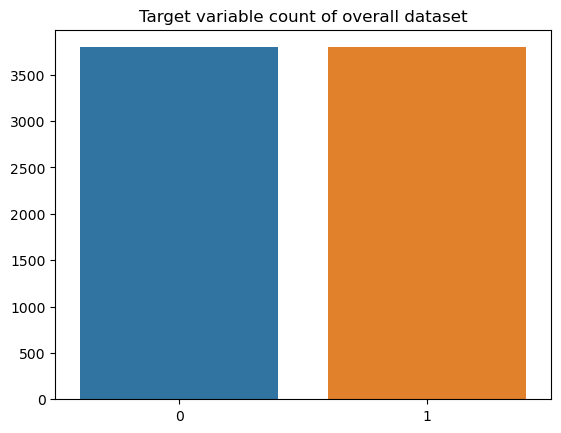

In [19]:
#checking for imbalance in the overall dataset
count = data['label'].value_counts().values
sns.barplot(x = [0,1], y = count)
plt.title('Target variable count of overall dataset')
plt.show()

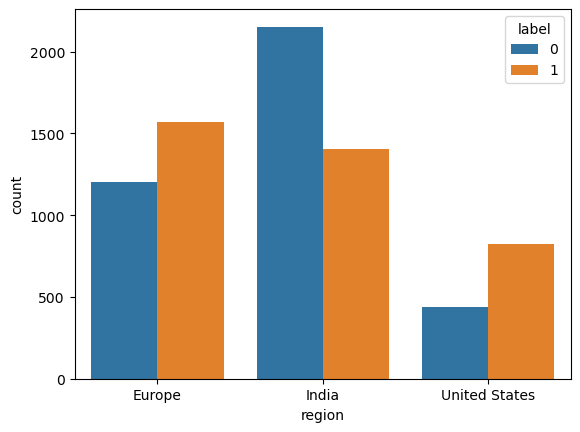

In [20]:
#distribution of fake and real news among counties
plt.figure
sns.countplot(x = "region", data=data, hue = "label")
plt.show()

In [21]:
data['label'].value_counts()

1    3795
0    3793
Name: label, dtype: int64

### Analysing dataset of Indian Region

In [22]:
India_data = data[data['region'] =='India'] 
India_data

,date posted,link,text,region,label
2,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,This video shows workmen uncovering a bat-inf...,India,1
3,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,The Asterix comic books and The Simpsons pred...,India,1
4,2/7/20,https://www.poynter.org/?ifcn_misinformation=c...,Chinese President Xi Jinping visited a mosque...,India,1
6,2/8/20,https://www.poynter.org/?ifcn_misinformation=p...,A video shows people screaming in Wuhan becau...,India,1
7,2/8/20,https://www.poynter.org/?ifcn_misinformation=w...,A video says weed kills coronavirus.\t\t,India,1
...,...,...,...,...,...
7576,6/30/20,https://twitter.com/IndiaToday/status/12778653...,The US has reported more than double the Covid...,India,0
7577,6/30/20,https://twitter.com/IndiaToday/status/12779087...,"""Washings hands many times a day and using san...",India,0
7578,6/30/20,https://twitter.com/IndiaToday/status/12779948...,#CoronavirusInIndia | #Gandhinagar develops AI...,India,0
7579,6/30/20,https://twitter.com/IndiaToday/status/12779824...,"#CoronavirusInIndia | #Maharashtra reports 4,8...",India,0


In [23]:
India_data['label'].value_counts()

0    2152
1    1403
Name: label, dtype: int64

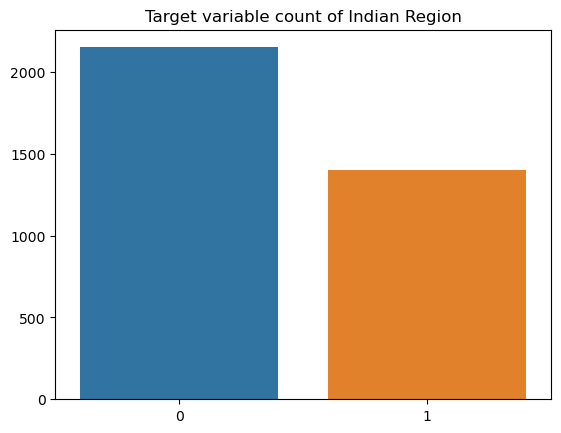

In [24]:
#checking for imbalance in the dataset of indian region
India_count = India_data['label'].value_counts().values
sns.barplot(x = [0,1], y = India_count)
plt.title('Target variable count of Indian Region')
plt.show()

### Analysing dataset of European region

In [25]:
Europe_data = data[data['region'] =='Europe'] 
Europe_data

,date posted,link,text,region,label
0,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Tencent revealed the real number of deaths.\t\t,Europe,1
1,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,Taking chlorine dioxide helps fight coronavir...,Europe,1
12,2/9/20,https://www.poynter.org/?ifcn_misinformation=c...,Coronavirus is caused by snakes.\t\t,Europe,1
17,2/10/20,https://www.poynter.org/?ifcn_misinformation=b...,Bill Gates predicted coronavirus.\t\t,Europe,1
18,2/10/20,https://www.poynter.org/?ifcn_misinformation=a...,Bill Gates predicted coronavirus.\t\t,Europe,1
...,...,...,...,...,...
7582,6/30/20,https://twitter.com/ReutersUK/status/127782796...,India's first COVID-19 vaccine candidate appro...,Europe,0
7583,6/30/20,https://twitter.com/ReutersUK/status/127789851...,Global COVID-19 prevention trial of hydroxychl...,Europe,0
7584,6/30/20,https://twitter.com/ReutersUK/status/127798902...,Bavaria's free COVID-19 test for all splits Ge...,Europe,0
7585,6/30/20,https://twitter.com/ReutersUK/status/127787577...,Britain locks down city of Leicester after COV...,Europe,0


In [26]:
Europe_data['label'].value_counts()

1    1569
0    1202
Name: label, dtype: int64

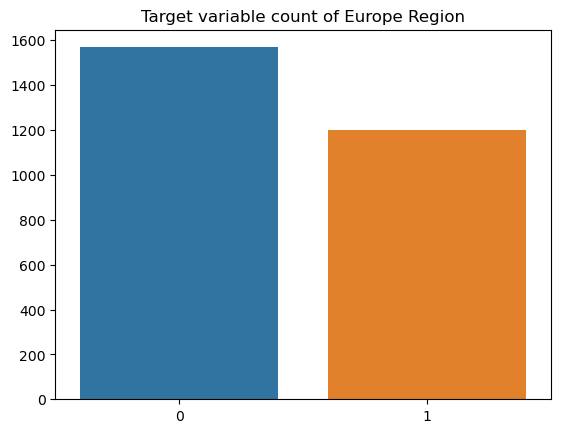

In [27]:
#checking for imbalance in the dataset of European region
Europe_count = Europe_data['label'].value_counts().values
sns.barplot(x = [0,1], y = Europe_count)
plt.title('Target variable count of Europe Region')
plt.show()

### Analysing dataset of US region

In [28]:
US_data = data[data['region'] =='United States'] 
US_data

,date posted,link,text,region,label
5,2/7/20,https://www.poynter.org/?ifcn_misinformation=c...,"China seeks court approval to kill over 20,00...",United States,1
10,2/8/20,https://www.poynter.org/?ifcn_misinformation=a...,Autopsy reveals a Wuhan doctor was murdered i...,United States,1
11,2/8/20,https://www.poynter.org/?ifcn_misinformation=s...,"The new coronavirus ""causes sudden death synd...",United States,1
33,2/11/20,https://www.poynter.org/?ifcn_misinformation=b...,"""Breaking",United States,1
43,2/12/20,https://www.poynter.org/?ifcn_misinformation=t...,The coronavirus pandemic can be dramatically ...,United States,1
...,...,...,...,...,...
7563,6/29/20,https://twitter.com/nytimes/status/12776271280...,Until recently remdesivir was the only drug sh...,United States,0
7564,6/29/20,https://twitter.com/washingtonpost/status/1277...,Perspective: Covid-19 outbreaks at jails and p...,United States,0
7565,6/29/20,https://twitter.com/washingtonpost/status/1277...,"Covid-19 treatment remdesivir priced at $3,120...",United States,0
7566,6/29/20,https://twitter.com/washingtonpost/status/1277...,This Italian hilltown is covid-free. But as it...,United States,0


In [29]:
US_data['label'].value_counts()

1    823
0    439
Name: label, dtype: int64

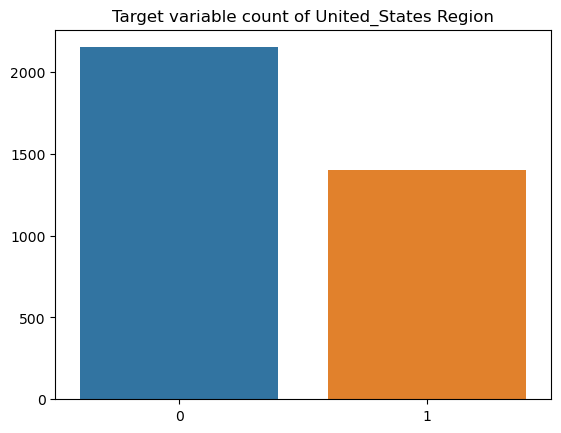

In [30]:
#checking for imbalance in the dataset of United States region
US_count = India_data['label'].value_counts().values
sns.barplot(x = [0,1], y = US_count)
plt.title('Target variable count of United_States Region')
plt.show()

In [31]:
#choosing the language as english
stop = set(stopwords.words('english'))

#removing punctuation marks
punctuation = list(string.punctuation)

#adding punctuations to the list of stop words 
stop.update(punctuation)

In [32]:
#Removing the square brackets
def remove_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [33]:
# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

In [90]:
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    text = text.lower()
    for i in text.split():
        if i.strip() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

In [35]:
# adding all the functions from above
def clean_text(text):
    text = remove_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text

In [93]:
#stop_words = set(stopwords.words('english'))
 
#word_tokens = word_tokenize(text)
 
#filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
 
#filtered_sentence = []
 
#for w in word_tokens:
#    if w not in stop_words:
#        filtered_sentence.append(w)
 
#print(word_tokens)
#print(filtered_sentence)

In [36]:
#Apply function on text column
data['text']=data['text'].apply(clean_text)
data['text']

0                    tencent revealed real number deaths.
1        taking chlorine dioxide helps fight coronavirus.
2       video shows workmen uncovering bat-infested ro...
3       asterix comic books simpsons predicted coronav...
4       chinese president xi jinping visited mosque am...
                              ...                        
7583    global covid-19 prevention trial hydroxychloro...
7584    bavaria's free covid-19 test splits germany pi...
7585    britain locks city leicester covid-19 flare-up...
7586    uk imposes lockdown city leicester curb covid-...
7587    grace fusco, matriarch large new jersey family...
Name: text, Length: 7588, dtype: object

### N-gram Analysis

In [37]:
#finding n-grams
texts = ''.join(str(data['text'].tolist()))

# first get individual words
tokenized = texts.split()

In [38]:
#unigram
unigram = (pd.Series(nltk.ngrams(tokenized, 1)).value_counts())[:30]
unigram.sort_values().plot.barh(width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Unigrams')
plt.ylabel('Unigram')
plt.xlabel('No: of Occurances')

Text(0.5, 0, 'No: of Occurances')

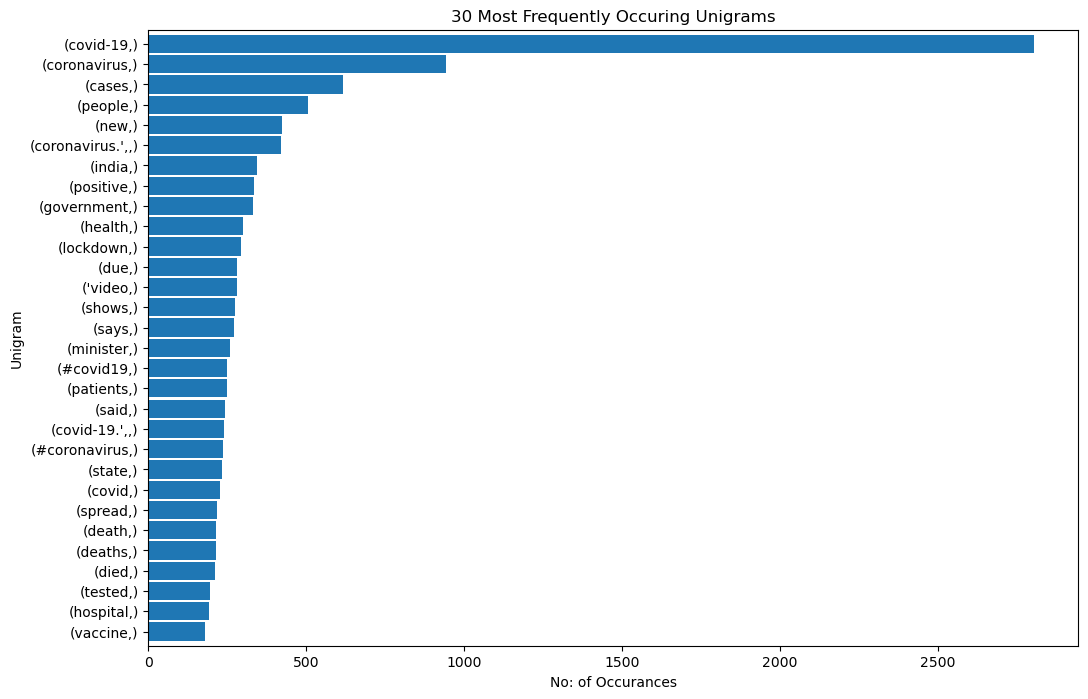

In [39]:
plt.show()

In [40]:
#bigrams
bigram = (pd.Series(nltk.ngrams(tokenized, 2)).value_counts())[:30]
bigram.sort_values().plot.barh(width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('No. of Occurances')

Text(0.5, 0, 'No. of Occurances')

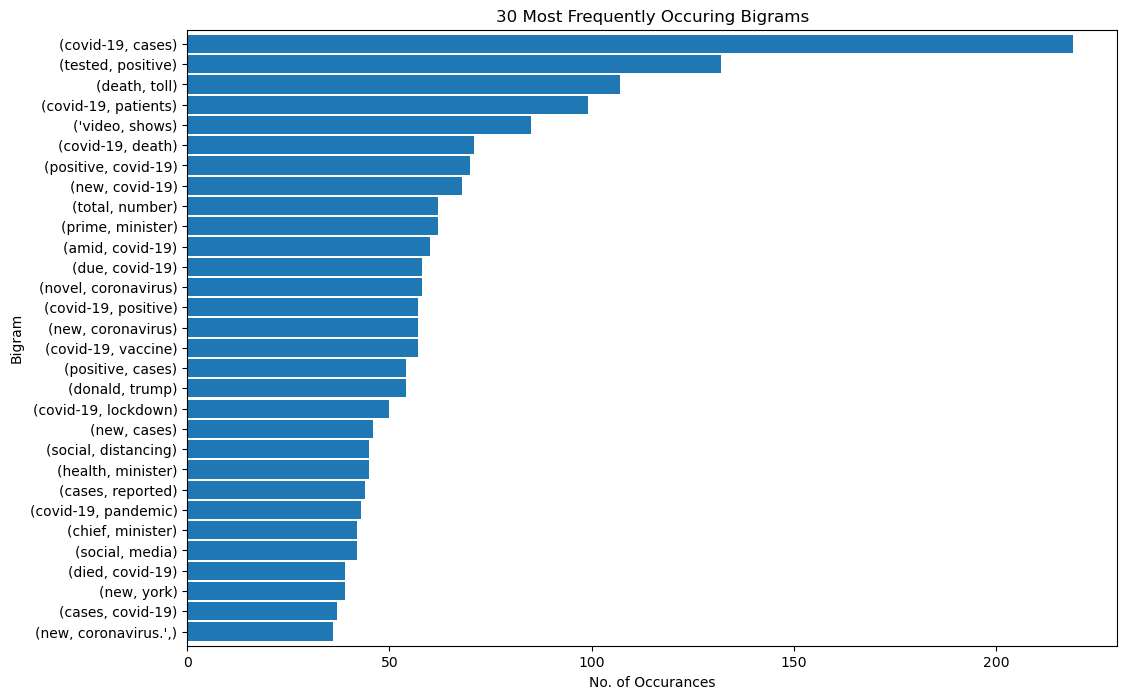

In [41]:
plt.show()

In [42]:
#trigrams
trigram = (pd.Series(nltk.ngrams(tokenized, 3)).value_counts())[:30]
trigram.sort_values().plot.barh(width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('No: of Occurances')

Text(0.5, 0, 'No: of Occurances')

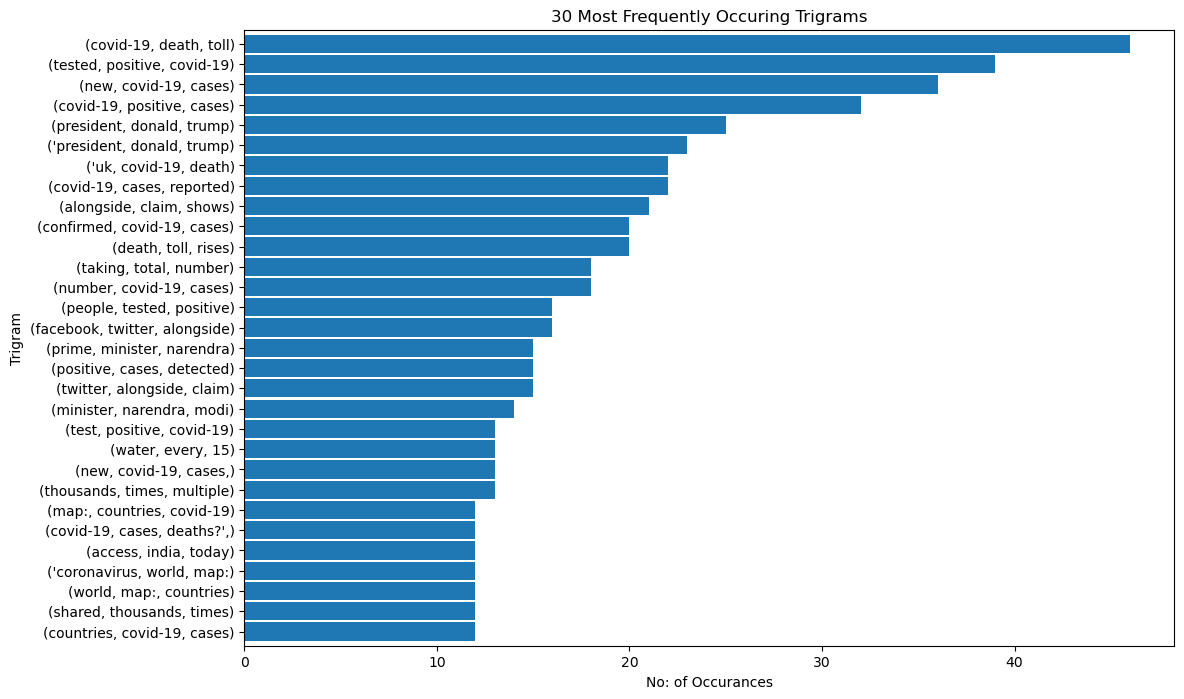

In [43]:
plt.show()

### Word Cloud

In [44]:
# join all texts in resective labels
all_texts_real = " ".join(data[data['label']==0]['text'])
all_texts_fake = " ".join(data[data['label']==1]['text'])

### Wordcloud for real news

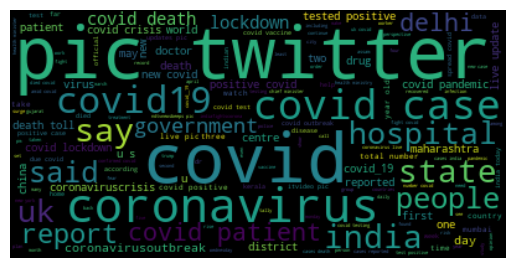

In [45]:
wordcloud = WordCloud().generate(all_texts_real)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Wordcloud for fake news

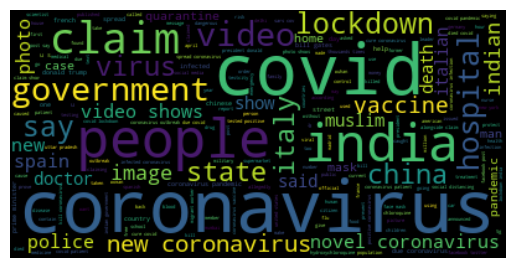

In [46]:
wordcloud = WordCloud().generate(all_texts_fake)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Analysing number of words in real and fake news

In [47]:
# tokenize words within the sequences
#data['sent_word_tokens'] = data['sent_tokens'].apply(lambda x: [word_tokenize(each_sentence) for each_sentence in x])

# Clean the punctuations
#def get_seq_tokens_cleaned(seq_tokens):
 # no_punc_seq = [each_seq.translate(str.maketrans('', '', string.punctuation)) for each_seq in seq_tokens]
  #sent_word_tokens = [word_tokenize(each_sentence) for each_sentence in no_punc_seq]
  #return sent_word_tokens

# Count the avg number of words in each sentence
#def get_average_words_in_sent(seq_word_tokens):
 # return np.mean([len(seq) for seq in seq_word_tokens])

#data['sent_word_tokens'] = data['sent_tokens'].apply(lambda x: get_seq_tokens_cleaned(x))
#data['avg_words_per_sent'] = data['sent_word_tokens'].apply(lambda x: get_average_words_in_sent(x))

#sns.boxplot(y='avg_words_per_sent', x='label', data=data, palette="Set3")
#plt.title("Boxplot of the Average Number of Words per Sentence in Fake and Genuine Articles")
#plt.show()

### Stemming

In [48]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

porter=PorterStemmer()

def stemSentence(text):
    token_words=word_tokenize(text)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [49]:
# Apply function on text column
data['text']=data['text'].apply(stemSentence)
data

,date posted,link,text,region,label
0,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,tencent reveal real number death .,Europe,1
1,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,take chlorin dioxid help fight coronaviru .,Europe,1
2,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,video show workmen uncov bat-infest roof us st...,India,1
3,2/7/20,https://www.poynter.org/?ifcn_misinformation=t...,asterix comic book simpson predict coronaviru ...,India,1
4,2/7/20,https://www.poynter.org/?ifcn_misinformation=c...,chines presid xi jinp visit mosqu amid coronav...,India,1
...,...,...,...,...,...
7583,6/30/20,https://twitter.com/ReutersUK/status/127789851...,global covid-19 prevent trial hydroxychloroqui...,Europe,0
7584,6/30/20,https://twitter.com/ReutersUK/status/127798902...,bavaria 's free covid-19 test split germani pi...,Europe,0
7585,6/30/20,https://twitter.com/ReutersUK/status/127787577...,britain lock citi leicest covid-19 flare-up pi...,Europe,0
7586,6/30/20,https://twitter.com/ReutersUK/status/127778649...,uk impos lockdown citi leicest curb covid-19 o...,Europe,0


In [50]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer()
#X = vectorizer.fit_transform('text')
#vectorizer.get_feature_names_out()
#print(X.shape)


# 3. Data Modelling

### Machine Learning model for fake news prediction
### Identifying the classifier Accuracy

In [51]:
x = data["text"]
y = data["label"]

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .25)

### Using Tfidf Vectorizer

In [53]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

### i. Logistic Regression

In [54]:
LR = LogisticRegression()
LR.fit(xv_train, y_train)

LogisticRegression()

In [55]:
LR.score(xv_test, y_test)

0.9288350026357406

In [56]:
pred_LR = LR.predict(xv_test)
y_pred_proba = LR.predict_proba(xv_test)

In [57]:
print(classification_report(y_test, pred_LR))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       951
           1       0.93      0.92      0.93       946

    accuracy                           0.93      1897
   macro avg       0.93      0.93      0.93      1897
weighted avg       0.93      0.93      0.93      1897



### ii. Decision Tree Classifier

In [58]:
DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

DecisionTreeClassifier()

In [59]:
DT.score(xv_test, y_test)

0.8866631523458092

In [60]:
pred_DT = DT.predict(xv_test)

In [61]:
print(classification_report(y_test, pred_DT))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       951
           1       0.87      0.90      0.89       946

    accuracy                           0.89      1897
   macro avg       0.89      0.89      0.89      1897
weighted avg       0.89      0.89      0.89      1897



### iii. K Neighbors Classifier

In [62]:
KNN = KNeighborsClassifier()
KNN.fit(xv_train, y_train)

KNeighborsClassifier()

In [63]:
KNN.score(xv_test, y_test)

0.8629414865577227

In [64]:
pred_KNN = KNN.predict(xv_test)

In [65]:
print(classification_report(y_test, pred_KNN))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       951
           1       0.81      0.95      0.87       946

    accuracy                           0.86      1897
   macro avg       0.87      0.86      0.86      1897
weighted avg       0.87      0.86      0.86      1897



### iv. Gradient Boosting Classifier

In [66]:
GBC = GradientBoostingClassifier(random_state = 0)
GBC.fit(xv_train, y_train)

GradientBoostingClassifier(random_state=0)

In [67]:
GBC.score(xv_test, y_test)

0.9167105956773853

In [68]:
pred_GBC = GBC.predict(xv_test)

In [69]:
print(classification_report(y_test, pred_GBC))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       951
           1       0.96      0.87      0.91       946

    accuracy                           0.92      1897
   macro avg       0.92      0.92      0.92      1897
weighted avg       0.92      0.92      0.92      1897



### v. Random Forest Classifier

In [70]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)

RandomForestClassifier(random_state=0)

In [71]:
RFC.score(xv_test, y_test)

0.9430680021085925

In [72]:
pred_RFC = RFC.predict(xv_test)
y_pred_proba = RFC.predict_proba(xv_test)

In [73]:
print(classification_report(y_test, pred_RFC))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       951
           1       0.95      0.93      0.94       946

    accuracy                           0.94      1897
   macro avg       0.94      0.94      0.94      1897
weighted avg       0.94      0.94      0.94      1897



In [74]:
#import matplotlib.pyplot as plt
#from sklearn.datasets import make_classification
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.model_selection import train_test_split

#X, y = make_classification(random_state=0)


#RFC.fit(xv_train, y_train)
#plot_confusion_matrix(RFC, xv_test, y_test)  
#plt.show()

### Testing the data

In [75]:
def classify_message(text):
    text = vectorization.transform(text)
    predicted = RFC.predict(text)
    probability = RFC.predict_proba(text).max()*100

    if predicted==0:
             print("The news is Real")
             print('the probability percentage is:',round(probability))
    else:
             print("The news is Fake")
             print('the probability percentage is:',round(probability))

In [97]:
text = ["STOCKHOLM—In recognition of their breakthrough studies revealing how the human nervous system responds to extremely high temperatures, heavily bandaged scientists David Julius and Ardem Patapoutian were reportedly wheeled in from a burn ward Monday to accept a Nobel Prize for their work in heat and sensory research. We want to thank the Nobel Committee for—oh God, oh God, oh God, it hurts said Patapoutian, who spoke through a thick layer of medical gauze and struggled to be heard over the continuous screams of Julius, with whom he shares the award for outstanding work in the field of physiology or medicine."
]

classify_message(text)

The news is Fake
the probability percentage is: 96


In [110]:
from nltk import sent_tokenize
 
data['sent_tokens'] = data['text'].apply(sent_tokenize)

In [121]:
#data['len_sentence'] = data['sent_tokens'].apply(len)
#sns.boxplot(y='len_sentence', x='label', data=data, palette="Set3")
#plt.title("Boxplot of Number of Sentences in Real and Fake Articles")
#plt.show()